<center><h1>Assignment 1</h1></center>

In the following document one can find my solutions for the given exercises. This code will be based on the code Jan Nagler provided originally and will contain the necessary changes. The exercises are as followed:

**a**. Derive the corresponding system of equations for S, I, R and D. E.g., $\frac{dD}{dt} = \mu I$ but this is not the only difference to SIR. In addition, the basic
reproduction number may now depend on µ as well, how? 

**b**. Assume that the basic reproduction number $R_0$ for B.1.1.7 is not exactly known but only the range $R_0 \in [3.0; 4.0]$. Assume that the mortality rate µ is also not exactly known but only the range $\mu \in [0.4\%; 4\%]$. Study how these parameter uncertainties affect the prediction of D at t = 365d.

**c**. Study numerically the effects of a hard versus soft lockdown (by two for you reasonable values of β), in terms of D(365d). Assume µ = 1% and a γ compatible with $R_0$ = 4. 
<br>
<br>
<br>
First of all, wee need to import some packages, so that we can use their code.

In [1]:
#### Imports ####
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# set matplotlib to inline
%matplotlib inline

Next, let us define the prerequists for this assignment, namely the population size, and its initial conditions. Where $N$ = Population Size, $I_0$ the total number of infected people at time zero and $R_0$ the total number of recovered people from the illness and $D_0$ the death at time zero.

<div class="alert alert-block alert-info">
<b>Note:</b> From here on forwards most of the code will be in markdown, since it is only examplatory. Since the exercise requires a little bit of experimentation, later on we will develop a class which contain this hereafter defined code.
</div>

```python
# Population size
N = 84e7

# Initial conditions: 1 Infected, no Recovered individuals
I0, R0, D0 = 100, 0, 0 #case zero
```

In order to use the $SIR(D)$ Model, we also need to calculate $S_0$, which is the number of susceptible persons. We can calculate this using over already defined values of $N$, $I_0$, $D_0$ and $R_0$.

```python
# All others, S=N-I-R susceptible, initially S0=N-I0-R0
S0 = N - I0 - R0 - D0 #normalization
```

Moreover, we need to define a initial contact rate, a recovery rate and the mortility rate, in order to calculate the events over time. We will name the contact rate $\beta$, the recovery rate $\gamma$ and the mortility rate $\mu$.

<div class="alert alert-block alert-warning">
<b>Be aware:</b> The following values are randomly choose by me.  
</div>

```python
# Contact rate, beta; recovery rate, gamma; mortility rate, mu
beta, gamma, mu = 0.8, 0.15, 0.05
```

The **basic reproduction number $R_0$ (*spoken R nought*)** is the average number *of cases directly generated by one case in a population where all individuals are susceptible to infection* [[1](https://en.wikipedia.org/wiki/Basic_reproduction_number)]. It is calculated by dividing the contact rate through the recovery rate.

```python
R_nought = beta / (gamma + mu)
# for further information see here: https://www.sciencedirect.com/topics/medicine-and-dentistry/basic-reproduction-number
```

In order to model the different things over time, we need to create a time variable. It will be named $t$.

```python
# A grid of time points (in days)
t = np.linspace(0, 365, 365)
```

Next we can set up the $SIR(D)$ model. I will use the given function by Jan Nagler and alter it a bit, in order to incorperate the mortility rate $\mu$.

```python
# SIRD model (coupled nonlinear system of ODEs)
def deriv(y, t, N, beta, gamma, mu):
    """Altered function for the SIRD.
    """
    S, I, R, D = y
    # dSdt = - contact rate * the susceptibles * infected / total population
    # How many of the population is susceptible to the virus?
    dSdt = -beta * S * I / N
    # dIdt = contact rate * susceptibles * infected / total population - recovery rate * infected
    # How many of the susceptibles will contract the virus?
    dIdt = beta * S * I / N - gamma * I - mu * I
    # dRdt = recovery rate * infected
    # How many of those that are infected recover excluded those that die?
    dRdt = gamma * I
    # dDdt = mortility rate * infected
    # How many of those that are infected will die?
    dDdt = mu * I
    return dSdt, dIdt, dRdt, dDdt
```

In order to continue we need to set up an initial conditions vector, in order to use later the ```odeint()``` function.

```python
# Initial conditions vector
y0 = S0, I0, R0, D0
```

Now, we will make use of the aforementioned ```odeint()``` function, which *integrates a system of ordinary differential equations* [[2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)]. The first argument for that function must be therefore a callable object, like a function (e.g. *a callable object is everything which can be called using ```()```*). Its second argument its the vector with the initial conditions, in our case the just defined `y0`. Third, we have to specify the time variable. As you can remember we did this, when $t$ was defined. In order to pass the function arguments to our given callable, we also need to specify the argument `args` with all the inputs the callable needs.

```python
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, mu))
```

The object `ret` now contains all the integrated differential equations. In order to use them correctly, we need to transpose them. In that way, we can extract all the different values for our equations.

```python
S, I, R, D = ret.T # return vector
```

Yet another quite important number, when it comes to epidemiology is the so called **effective reproduction number**, which will be denoted $R_{effective}$. The idea of this number is, that to any given time $t$ an unknown number of the susceptible is immune to the disease, *or the average number of new infections caused by a single infected individual at time t in the partially susceptible population* [[3](https://en.wikipedia.org/wiki/Basic_reproduction_number#Effective_reproduction_number), [4](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory)]. As soon as this number drops below one, one can speak of *herd immunity*. Thus $R_e$ can be defined by $R_0 * \frac{susceptibles}{population}$.

For our model, we can calculate this using the following loop.

```python
t_1 = 0
for time in range(0,len(S)):
    if R_nought*S[time]/N < 1: 
        t_1 = time
        break
display(Markdown(rf"$R_e$ = 1 after {t_1} days"))
```

## Class development
Above we have seen, which variables and function we will need in order to calculate the different things. In the next cell, we will define a class which can take of all those things. The advantage of using a class is, that we can easily change the parameter and see how changing one parameter impacts the others.

In [2]:
class SIRD:
    """This class incorporates the SIRD model"""

    def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float, gamma: float, mu: float, days: int):
        self.N = N
        self.S0 = N - I0 - R0 - D0
        self.I0 = I0
        self.R0 = R0
        self.D0 = D0
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.R_nought = beta / (gamma + mu)
        self.t = np.linspace(0, days, days)
    
    def _deriv(self, y, t, N, beta, gamma, mu):
        """Altered function for the SIRD.
        """
        S, I, R, D = y
        # dSdt = - contact rate * the susceptibles * infected / total population
        # How many of the population is susceptible to the virus?
        dSdt = -beta * S * I / N
        # dIdt = contact rate * susceptibles * infected / total population - recovery rate * infected - 
        # mortality rate * infected
        # How many of the susceptibles will contract the virus?
        dIdt = beta * S * I / N - gamma * I - mu * I
        # dRdt = recovery rate * infected
        # How many of those that are infected recover excluded those that die?
        dRdt = gamma * I
        # dDdt = mortility rate * infected
        # How many of those that are infected will die?
        dDdt = mu * I
        return dSdt, dIdt, dRdt, dDdt
    
    def _R_effective(self, subplot = False):
        self.t_1 = 0
        for time in range(0,len(self.S)):
            if self.R_nought*self.S[time]/self.N < 1: 
                self.t_1 = time
                break
        if not subplot:
            display(Markdown(rf"$R_e$ = 1 after {self.t_1} days!"))
    
    def _ode(self):
        y0 = self.S0, self.I0, self.R0, self.D0
        ret = odeint(self._deriv, y0, self.t, args=(self.N, self.beta, self.gamma, self.mu))
        self.S, self.I, self.R, self.D = ret.T
        
    def plot(self, subplot = False):
        self._ode()
        self._R_effective(subplot)
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(self.t, self.S/self.N, alpha=0.5, lw=2, label='$S_{usceptible}$')
        ax.plot(self.t, self.I/self.N, alpha=0.5, lw=2, label='$I_{nfected}$')
        ax.plot(self.t, self.R/self.N, alpha=0.5, lw=2, label='$R_{ecovered}$')
        ax.plot(self.t, self.D/self.N, alpha=0.5, lw=2, label='$D_{eath}$')
        ax.plot(self.t, self.R_nought*self.S/self.N, alpha=0.5, lw=2, label='$R_{effective}$')
        ax.plot(self.t, np.full(len(self.t), self.R_nought), alpha=0.5, lw=2, label='$R_{nought}$')
        ax.set_xlabel('Time / days')
        ax.set_ylabel('Fraction')
        ax.set_ylim(0,2.2)
        ax.vlines(self.t_1, 0, 1, colors='k', linestyles='dashed')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend(fontsize="large", loc = "upper right")
        legend.get_frame().set_alpha(0.5)
        
        plt.text(0.2, 0.75, f"The BRN is: {round(self.R_nought,2)}",
                     transform=ax.transAxes)
        plt.text(0.2, 0.4, f"D = t(365): {round(self.D[-1],2)}",
                     transform=ax.transAxes)
        
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        if subplot:
            x = list(map(lambda x: plt.gca().lines[x].get_xdata(), range(5)))
            y = list(map(lambda x: plt.gca().lines[x].get_ydata(), range(5)))
            lines, labels = ax.get_legend_handles_labels()
            plt.close()
            return x, y, lines, labels
        else:
            plt.show()
        
    def subplots(self, variable_to_test: str, test: range, subplot_title: str):
        f, axs = plt.subplots(1, len(test), sharey = True, figsize=(15,7))
        resetter = getattr(self, variable_to_test)
        for k,v in enumerate(test):
            setattr(self, variable_to_test, v)
            model = SIRD(self.N, self.I0, self.R0, self.D0, self.beta, self.gamma, self.mu, len(self.t))
            x, y, lines, labels = model.plot(subplot = True)
            for j in range(len(x)):
                axs[k].plot(x[j], y[j])
                axs[k].set_title(f"{subplot_title}: {v}")
            plt.text(0.2, 0.4, f"D = t(365): {round(model.D[-1],2)}",
                     transform=axs[k].transAxes)
            plt.text(0.2, 0.75, f"The BRN is: {round(model.R_nought,2)}",
                     transform=axs[k].transAxes)
        f.legend(lines, labels, loc = 'upper right', fontsize="large", facecolor= "white")
        setattr(self, variable_to_test, resetter)

In [3]:
model = SIRD(N = 3000, I0 = 7, R0 = 0, D0 = 0,
            beta = 0.39, gamma = 0.15, mu = 0,
            days= 365)
# model.plot()

<div class="alert alert-block alert-warning">
<b>Be aware:</b> In the following subplots all values are fixed, only the ones displayed on top of the respective subplots are changed!  
</div>

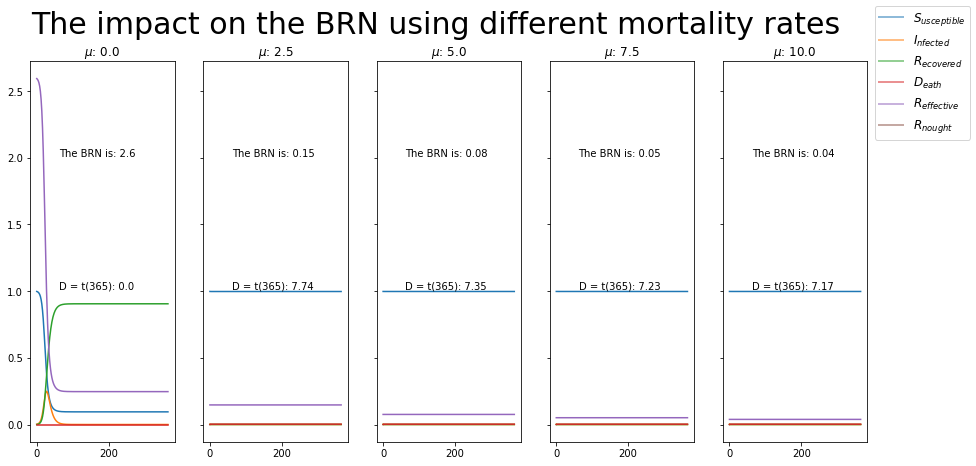

In [4]:
model.subplots("mu", list(map(lambda x: x/10.0, range(0, 125, 25))), "$\mu$")
plt.suptitle("The impact on the BRN using different mortality rates", fontsize = 30)
plt.savefig("Impact from the mortality rate on BRN.png")
plt.show()

**Answer here for question a!**

My take: The higher $\mu$ the lower the BRN.

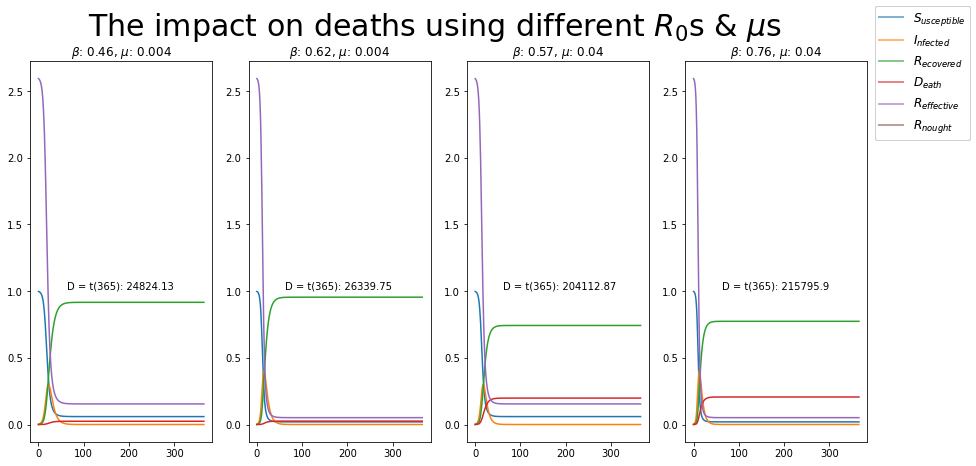

In [5]:
R_nought = [3.0,4.0]
mu = [0.004, 0.04]
beta = []
f, axs = plt.subplots(1, 4, figsize=(15,7))
i = 1
for mortality_rate in mu:
    for  basic_repr_nr in R_nought:
        model.beta = basic_repr_nr*(model.gamma + mortality_rate)
        model.mu = mortality_rate
        x, y, lines, labels = model.plot(subplot = True)
        for j in range(len(x)):
            axs[i-1].plot(x[j], y[j])
            axs[i-1].set_title(rf"$\beta$: {round(model.beta, 2)}, $\mu$: {model.mu}")
        plt.text(0.2, 0.4, f"D = t(365): {round(sum(model.D),2)}",
                    transform=axs[i-1].transAxes)
        f.legend(lines, labels, loc = 'upper right', fontsize="large", facecolor= "white")
        i += 1
plt.suptitle("The impact on deaths using different $R_0$s & $\mu$s", fontsize = 30)
plt.savefig("Impact from BRN & Mu on deaths.png")
plt.show()

**Answer here for question b!**

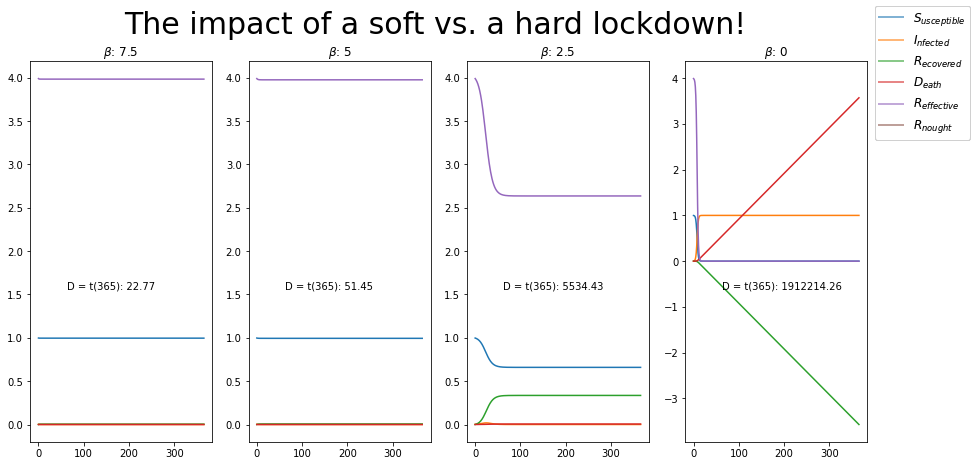

In [6]:
model.mu = 0.01
model.R_nought = 4
beta = [0, 2.5, 5, 7.5][::-1]
f, axs = plt.subplots(1, 4, figsize=(15,7))
i = 1
for infection_rate in beta:
    model.gamma = (infection_rate/model.R_nought) - model.mu
    x, y, lines, labels = model.plot(subplot = True)
    for j in range(len(x)):
        axs[i-1].plot(x[j], y[j])
        axs[i-1].set_title(rf"$\beta$: {infection_rate}")
    plt.text(0.2, 0.4, f"D = t(365): {round(sum(model.D),2)}",
                transform=axs[i-1].transAxes)
    f.legend(lines, labels, loc = 'upper right', fontsize="large", facecolor= "white")
    i += 1
plt.suptitle("The impact of a soft vs. a hard lockdown!", fontsize = 30)
plt.savefig("Impact of contact restrictions.png")
plt.show()

**Answer here for question c!**